<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

###GRAPE code running System identification problems

Allan De Lima, Douglas Dias, Samuel Carvalho

The following notebook implements a GE solution for three benchmark system identification problems: Silverbox, Coupled Drives and Wiener-Hammersten. More details about these datasets can be seen at www.nonlinearbenchmark.org.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Clone this repository in which we have all functions and classes created or adapted to this work, if needed. If not, just cd into the /deap_ge folder.

Import all the necessary libraries and install deap 1.3 if not yet available.

In [2]:
#import os.path

#PATH = '/content/drive/MyDrive/deap_ge/'
#if os.path.exists(PATH):
#    print('deap_ge directory already exists')
#else:
#    %cd /content/drive/MyDrive/
#    !git clone https://github.com/danozu/deap_ge.git 
#    print('Cloning deap_ge in your Drive')
%ls
%cd ./deap_ge/

deap_ge/  GE_System_Identification_Problems.ipynb
/home/samuel/Grape for SysID/deap_ge


In [3]:
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")

#!pip install deap==1.3 
from ponyge2_adapted_files import Grammar, ge
from functions import div, plog, psqrt, exp
import algorithms
import math
import time
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
import random
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools

In [4]:
# Setting a random seed for repeatability
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Starting timer to measure execution time 
t = time.time()

Set a system identification problem to solve. For now, we can choose among 'silverbox', 'coupled' and 'wienerhammerstein'.

In [5]:
#problem = 'silverbox'
problem = 'coupled'
#problem = 'wienerhammerstein'

Read datasets and grammars according to the problem picked in the previous cell. This piece of code will also create the lag matrices we need for the features and the Gaussian white noise.

In [6]:
### Loading dataset

if problem == 'silverbox':
      
    ## Creating Training Features ##
        
    X_train = pd.read_csv('datasets/Silverbox/X_train.txt', sep='\t', header=0)
    X_train = np.array(X_train)
    X_train = X_train.astype(float)
    X_lagged_train = lagmat(X_train, maxlag=5, trim="forward", original='in')
    
    
    # X_lagged_train contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_train = pd.read_csv('datasets/Silverbox/Y_train.txt', header=0)
    Y_train = np.array(Y_train)
    Y_train = Y_train.astype(float)
    Y_train = Y_train.flatten()
    Y_lagged_train = lagmat(Y_train, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_train contains y[k-1] y[k-2] .... y[k-10]
    
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_train) 
    w_noise_train = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_train = lagmat(w_noise_train, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_train_features = np.concatenate((X_lagged_train,Y_lagged_train,w_noise_lagged_train),axis=1)
    X_train_features = np.transpose(X_train_features)
    
    
    ## Creating Test Features ##
    
    X_test = pd.read_csv('datasets/Silverbox/X_test.txt', sep='\t', header=0)
    X_test = np.array(X_test)
    X_test = X_test.astype(float)
    X_lagged_test = lagmat(X_test, maxlag=5, trim="forward", original='in')
    
    
    # X_lagged_test contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_test = pd.read_csv('datasets/Silverbox/Y_test.txt', header=0)
    Y_test = np.array(Y_test)
    Y_test = Y_test.astype(float)
    Y_test = Y_test.flatten()
    Y_lagged_test = lagmat(Y_test, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_test contains y[k-1] y[k-2] .... y[k-10]
    
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_test) 
    w_noise_test = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_test = lagmat(w_noise_test, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_test_features = np.concatenate((X_lagged_test,Y_lagged_test,w_noise_lagged_test),axis=1)
    X_test_features = np.transpose(X_test_features)
    
    
    ## Creating Validation (Prediction) Data ##
    
    X_val = pd.read_csv('datasets/Silverbox/X_validation.txt', sep='\t', header=0)
    X_val = np.array(X_val)
    X_val = X_val.astype(float)
    X_lagged_val= lagmat(X_val, maxlag=5, trim="forward", original='in')
       
    # X_lagged_val contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_val = pd.read_csv('datasets/Silverbox/Y_validation.txt', header=0)
    Y_val = np.array(Y_val)
    Y_val = Y_val.astype(float)
    Y_val = Y_val.flatten()
    Y_lagged_val = lagmat(Y_val, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_val contains y[k-1] y[k-2] .... y[k-10]
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_val) 
    w_noise_val = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_val = lagmat(w_noise_val, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_val_features = np.concatenate((X_lagged_val,Y_lagged_val,w_noise_lagged_val),axis=1)
    X_val_features = np.transpose(X_val_features)
         

    GRAMMAR_FILE = 'NARMAX.bnf'

In [7]:
if problem == 'coupled':
      
    ## Creating Training Features ##
        
    X_train = pd.read_csv('datasets/CoupledDrives/X_train.txt', sep='\t', header=0)
    X_train = np.array(X_train)
    X_train = X_train.astype(float)
    X_lagged_train = lagmat(X_train, maxlag=5, trim="forward", original='in')
    
    
    # X_lagged_train contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_train = pd.read_csv('datasets/CoupledDrives/Y_train.txt', header=0)
    Y_train = np.array(Y_train)
    Y_train = Y_train.astype(float)
    Y_train = Y_train.flatten()
    Y_lagged_train = lagmat(Y_train, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_train contains y[k-1] y[k-2] .... y[k-10]
    
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_train) 
    w_noise_train = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_train = lagmat(w_noise_train, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_train_features = np.concatenate((X_lagged_train,Y_lagged_train,w_noise_lagged_train),axis=1)
    X_train_features = np.transpose(X_train_features)
    
    
    ## Creating Test Features ##
    
    X_test = pd.read_csv('datasets/CoupledDrives/X_test.txt', sep='\t', header=0)
    X_test = np.array(X_test)
    X_test = X_test.astype(float)
    X_lagged_test = lagmat(X_test, maxlag=5, trim="forward", original='in')
    
    
    # X_lagged_test contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_test = pd.read_csv('datasets/CoupledDrives/Y_test.txt', header=0)
    Y_test = np.array(Y_test)
    Y_test = Y_test.astype(float)
    Y_test = Y_test.flatten()
    Y_lagged_test = lagmat(Y_test, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_test contains y[k-1] y[k-2] .... y[k-10]
    
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_test) 
    w_noise_test = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_test = lagmat(w_noise_test, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_test_features = np.concatenate((X_lagged_test,Y_lagged_test,w_noise_lagged_test),axis=1)
    X_test_features = np.transpose(X_test_features)
    
    
    ## Creating Validation (Prediction) Data  (Same as test in this case)##
    
    X_val = X_test
    X_lagged_val= X_lagged_test
       
    # X_lagged_val contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_val = Y_test
    Y_lagged_val = Y_lagged_test
    
    # Y_lagged_val contains y[k-1] y[k-2] .... y[k-10]
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_val) 
    w_noise_val = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_val = lagmat(w_noise_val, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_val_features = np.concatenate((X_lagged_val,Y_lagged_val,w_noise_lagged_val),axis=1)
    X_val_features = np.transpose(X_val_features)
         
    
    
    #GRAMMAR_FILE = 'Coupled_NARMAX_ext.bnf'
    GRAMMAR_FILE = 'NARMAX.bnf'
 

In [8]:
if problem == 'wienerhammerstein':
      
    ## Creating Training Features ##
        
    X_train = pd.read_csv('datasets/WienerHammerstein/X_train.txt', sep='\t', header=0)
    X_train = np.array(X_train)
    X_train = X_train.astype(float)
    X_lagged_train = lagmat(X_train, maxlag=5, trim="forward", original='in')
    
    
    # X_lagged_train contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_train = pd.read_csv('datasets/WienerHammerstein/Y_train.txt', header=0)
    Y_train = np.array(Y_train)
    Y_train = Y_train.astype(float)
    Y_train = Y_train.flatten()
    Y_lagged_train = lagmat(Y_train, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_train contains y[k-1] y[k-2] .... y[k-10]
    
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_train) 
    w_noise_train = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_train = lagmat(w_noise_train, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_train_features = np.concatenate((X_lagged_train,Y_lagged_train,w_noise_lagged_train),axis=1)
    X_train_features = np.transpose(X_train_features)
    
    
    ## Creating Test Features ##
    
    X_test = pd.read_csv('datasets/WienerHammerstein/X_test.txt', sep='\t', header=0)
    X_test = np.array(X_test)
    X_test = X_test.astype(float)
    X_lagged_test = lagmat(X_test, maxlag=5, trim="forward", original='in')
    
    
    # X_lagged_test contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_test = pd.read_csv('datasets/WienerHammerstein/Y_test.txt', header=0)
    Y_test = np.array(Y_test)
    Y_test = Y_test.astype(float)
    Y_test = Y_test.flatten()
    Y_lagged_test = lagmat(Y_test, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_test contains y[k-1] y[k-2] .... y[k-10]
    
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_test) 
    w_noise_test = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_test = lagmat(w_noise_test, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_test_features = np.concatenate((X_lagged_test,Y_lagged_test,w_noise_lagged_test),axis=1)
    X_test_features = np.transpose(X_test_features)
    
    
    ## Creating Validation (Prediction) Data ##
    
    X_val = pd.read_csv('datasets/WienerHammerstein/X_validation.txt', sep='\t', header=0)
    X_val = np.array(X_val)
    X_val = X_val.astype(float)
    X_lagged_val= lagmat(X_val, maxlag=5, trim="forward", original='in')
       
    # X_lagged_val contains x[k] x[k-1] x[k-2] x[k-3] x[k-4] x[k-5]
    
    Y_val = pd.read_csv('datasets/WienerHammerstein/Y_validation.txt', header=0)
    Y_val = np.array(Y_val)
    Y_val = Y_val.astype(float)
    Y_val = Y_val.flatten()
    Y_lagged_val = lagmat(Y_val, maxlag=10, trim="forward", original='ex')
    
    # Y_lagged_val contains y[k-1] y[k-2] .... y[k-10]
    
    # White noise process for simulation 

    mean = 0
    std = 0.0001 
    num_samples = len(Y_val) 
    w_noise_val = np.random.normal(mean, std, size=num_samples)
    w_noise_lagged_val = lagmat(w_noise_val, maxlag=5, trim="forward", original='in')
    
    # Concatenating all together we will have:
    # x[k] ... x[k-5]  | y[k-1] ... y[k-10] | w[k] ... w[k-5]    
    
    X_val_features = np.concatenate((X_lagged_val,Y_lagged_val,w_noise_lagged_val),axis=1)
    X_val_features = np.transpose(X_val_features)
    
    # White noise process for simulation 
        
        
    GRAMMAR_FILE = 'NARMAX.bnf'

Print grammar.

In [9]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close() 

<expression> ::= <terms> + <epsilon>

<terms> ::= <constant>*<inputterm>*<outputterm>*<noiseterm> |
	    <constant>*<inputterm>*<outputterm>*<noiseterm> + <terms>	  

<inputterm> ::= <input>| 
		np.power(<input>,<power>)| 
		<input>*<inputterm>|
		np.power(<input>,<power>)*<inputterm>|
		1

<outputterm> ::= <output>| 
		np.power(<output>,<power>)| 
		<output>*<outputterm>|
		np.power(<output>,<power>)*<outputterm>|
		1	        

<noiseterm> ::= <noise>| 
		np.power(<noise>,<power>)| 
		<noise>*<noiseterm>|
		np.power(<noise>,<power>)*<noiseterm>|
		1

<input>  ::= x[0]|x[1]|x[2]|x[3]|x[4]|x[5]
<output> ::= x[6]|x[7]|x[8]|x[9]|x[10]|x[10]|x[11]|x[12]|x[13]|x[14]|x[15]
<epsilon> ::= x[16]
<noise>  ::= x[17]|x[18]|x[19]|x[20]|x[21]


<power>    ::=  2 | 3 | 4 | 5	
<constant> ::=  +<c>.<c><c><c><c> | -<c>.<c><c><c><c>
<c>  ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9




Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [10]:
BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

         Unit productions consume GE codons.
         Unit productions consume GE codons.


Define some useulf functions for fitness calculation and individuals simulation:

In [11]:
# Function to prepare the individuals for simulation

# We need it to translate phenotypes for a simulation loop, since it will reuse its own previous outputs y_hat[i-x]   

def sim_prep(individual):
    
    best_individual = individual.phenotype
    
    # Input and past inputs
    best_individual = best_individual.replace('x[0]','inputs[0][i]')
    best_individual = best_individual.replace('x[1]','inputs[1][i]') 
    best_individual = best_individual.replace('x[2]','inputs[2][i]') 
    best_individual = best_individual.replace('x[3]','inputs[3][i]') 
    best_individual = best_individual.replace('x[4]','inputs[4][i]') 
    best_individual = best_individual.replace('x[5]','inputs[5][i]') 
    
    # Past outputs 
    best_individual = best_individual.replace('x[6]','y_hat[i-1]')
    best_individual = best_individual.replace('x[7]','y_hat[i-2]') 
    best_individual = best_individual.replace('x[8]','y_hat[i-3]') 
    best_individual = best_individual.replace('x[9]','y_hat[i-4]') 
    best_individual = best_individual.replace('x[10]','y_hat[i-5]') 
    best_individual = best_individual.replace('x[11]','y_hat[i-6]') 
    best_individual = best_individual.replace('x[12]','y_hat[i-7]') 
    best_individual = best_individual.replace('x[13]','y_hat[i-8]') 
    best_individual = best_individual.replace('x[14]','y_hat[i-9]') 
    best_individual = best_individual.replace('x[15]','y_hat[i-10]')
    
    # Noise terms: current and past observations
    best_individual = best_individual.replace('x[16]','inputs[16][i]')
    best_individual = best_individual.replace('x[17]','inputs[17][i]') 
    best_individual = best_individual.replace('x[18]','inputs[18][i]') 
    best_individual = best_individual.replace('x[19]','inputs[19][i]') 
    best_individual = best_individual.replace('x[20]','inputs[20][i]') 
    best_individual = best_individual.replace('x[21]','inputs[21][i]')   
    
    #print(best_individual)
    
    return best_individual

In [12]:
# Function for simulating an individual using the validation data set
# Returns the simulation RMSE and the output data y_hat

def simulate(individual):
    
    expression = sim_prep(individual)
    
     # Loading features
    inputs = X_val_features
    
    # Defining the output array and initial conditions
    y_hat = np.zeros(shape=(inputs.shape[1],1))
    
    # Maximum lag (order) for the simulation
    MAX_LAG = 10
    
    # Simulation for-loop
    for i in np.arange(MAX_LAG+1,inputs.shape[1]):
             
        y_hat[i] = eval(expression)
    
    # Try to calculate RMSE, if something goes wrong return a high value
    try:
        sim_RMSE = mean_squared_error(Y_val[MAX_LAG+1:], y_hat[MAX_LAG+1:], squared=False)
    except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError, ValueError):
        sim_RMSE = 50
    
    return sim_RMSE, y_hat

In [13]:
# Function for predicting an individual using the validation data set
# Returns the prediction RMSE and the output data y_pred

def predict(individual):
    
    expression = sim_prep(individual)
    
     # Loading features
    inputs = X_val_features
    
    # Defining the output array 
    y_pred = np.zeros(shape=(inputs.shape[1],1))
    
    # For prediction, the past observations will be taken from the dataset, not past outputs
    y_hat = Y_val
    
    # Maximum lag (order) for the simulation
    MAX_LAG = 10
    
    # Simulation for-loop
    for i in np.arange(MAX_LAG+1,inputs.shape[1]):
             
        y_pred[i] = eval(expression)
    
    # Try to calculate RMSE, if something goes wrong return high value
    try:
        pred_RMSE = mean_squared_error(Y_val[MAX_LAG+1:], y_pred[MAX_LAG+1:], squared=False)
    except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError, ValueError):
        pred_RMSE = 50
    
    return pred_RMSE, y_pred        


In [14]:
# Fitness function that will use the prediction RMSE

def fitness_eval(individual, points):
    #points = [X, Y]
    x = points[0]
    y = points[1]
    
    
    if individual.invalid == True:
        return np.NaN,

    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        #fitness = np.mean(np.square(y - pred))
        fitness = mean_squared_error(y,pred, squared=False)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        fitness = np.NaN
    
    if fitness == float("inf"):
      return np.NaN,    
    return fitness,    


In [15]:
# Fitness function that will use the simulation RMSE
# SIGNIFICANTLY SLOWER THAN fitness_eval

def sim_fitness_eval(individual, points):
    #points = [X, Y]
    x = points[0]
    y = points[1]
    
    
    if individual.invalid == True:
        return np.NaN,

    try:
        
        expression = sim_prep(individual)
                
         # Loading features
        inputs = x
        
        # Defining the output array and initial conditions
        y_hat = np.zeros(shape=(inputs.shape[1],1))
        
        # Maximum lag (order) for the simulation
        MAX_LAG = 10
        
        # Simulation for-loop
        for i in np.arange(MAX_LAG+1,inputs.shape[1]):
                 
            y_hat[i] = eval(expression)
        
        # Try to calculate RMSE, if something goes wrong return high value
        try:
            sim_RMSE = mean_squared_error(y[MAX_LAG+1:], y_hat[MAX_LAG+1:], squared=False)
        except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError, ValueError):
            sim_RMSE = 50
        
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        return np.NaN,
    assert np.isrealobj(y_hat)
     
    if sim_RMSE == float("inf"):
      return np.NaN,    
    return sim_RMSE,


In [16]:
# Fitness function that will use both the simulation and prediction RMSE values
# SIGNIFICANTLY SLOWER THAN fitness_eval

def comb_fitness(individual,points):
    
    p_error = fitness_eval(individual,points)
    s_error = sim_fitness_eval(individual,points)
    
    return p_error+s_error

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`ge.Individual` is a class with the following attributes: `phenotype`, `genome`, `tree`, `nodes`, `invalid` (True or False), `depth` and `used_codons`.

Usually, when using deap, we initialise each individual independently, and then we repeat that until we fill out the whole population. However, since we are using Position Independent Grow Initialisation, we need to initialise all individuals simultaneously.

`ge.selTournament` prevents selecting invalid individuals.

`ge.crossover_onepoint` selects crossover points within the used portion of the genome. 

Similarly, `ge.mutation_int_flip_per_codon` performs only over the effective length.



In [17]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


Set our Grammatical Evolution parameters.

In [18]:
POPULATION_SIZE = 100
MAX_GENERATIONS = 150
P_CROSSOVER = 0.95
P_MUTATION = 0.05
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 20
MIN_INIT_TREE_DEPTH = 5
MAX_TREE_DEPTH = 150
MAX_WRAPS = 0
CODON_SIZE = 255

Set the total number of runs that we want, and starts our mutex for getting readable prints on the output.

In [19]:
# Number of runs
N_RUNS = 12

# Mutex for the prints
lock = mp.Lock()

Here we define a function called evoloop(), in which the evolutionary loop will happen for each of the 
"N_RUNS" runs. This function will later be called inside a for loop that asynchronously distributes each instance to a core/thread in the processor using the multiprocessing library.  

In [20]:
# Function containing the evolutionary loop
def evoloop(run):
    
    # Run number
    r = run
    
    # create initial population (generation 0):
    population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
 
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)# if not ind.invalid else (np.NaN,))#ind.fitness.values != np.inf else None)
    stats.register("avg", np.nanmean)
    stats.register("std", np.nanstd)
    stats.register("min", np.nanmin)
    stats.register("max", np.nanmax)
    
    
    # Which run are we on?
    lock.acquire()
    print("\n\nCurrently on run", r+1, "of",N_RUNS)
    lock.release()
    
    # perform the Grammatical Evolution flow:
    population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[X_train_features, Y_train], 
                                          points_test=[X_test_features, Y_test], 
                                          stats=stats, halloffame=hof, verbose=False)
    
    import textwrap
    best = hof.items[0].phenotype
    
    # Printing outcome from this run
    lock.acquire()
    time.sleep(0.1)
    print("\n\nResults of run", r+1, "of",N_RUNS)
    print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
    print("\nTraining Fitness: ", hof.items[0].fitness.values[0])
    print("Test Fitness: ", fitness_eval(hof.items[0], [X_test_features,Y_test])[0])
    print("Depth: ", hof.items[0].depth)
    print("Length of the genome: ", len(hof.items[0].genome))
    print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
    
    val_fitness = fitness_eval(hof.items[0], [X_val_features,Y_val])[0]
    print("Validation Fitness: ", val_fitness)
    lock.release()
    
    
    return logbook, r+1 , val_fitness, hof.items[0]

Runs the evolutionary loop in parallel executions if N_RUNS>1 and extracts the statistics objects from them.

In [21]:
### Running the evoloop in parallel

# Defines our pool of processors using all available ones
pool = mp.Pool(mp.cpu_count())

# Runs the evoloop function in parallel, passing only r as the argument 
results = pool.starmap_async(evoloop, [([r]) for r in range(0, N_RUNS)]).get()

pool.close()

# Waits for all queued processes to reach here before resuming
pool.join() 


### Getting the objects from the runs, so we can extract statistics

logbooks, runs, val_fit, hallof = zip(*results)

print('\n\n==== Finished Parallel Runs ====\n\n')



Currently on run 3 of 12


Currently on run 1 of 12


Currently on run 8 of 12


Currently on run 6 of 12


Currently on run 12 of 12


Currently on run 4 of 12


Currently on run 5 of 12


Currently on run 10 of 12


Currently on run 9 of 12


Currently on run 2 of 12


Currently on run 7 of 12


Currently on run 11 of 12


Results of run 1 of 12
Best individual: 
 +1.0380*1*x[6]*1 + -0.0774*1*x[8]*1 + -7.2236*1*x[12]*x[20] +
-4.0174*x[1]*np.power(x[0],4)*1*1*x[17] + +0.0374*np.power(x[4],4)*1*x[19] +
+0.3453*1*np.power(x[7],2)*x[12]*np.power(x[21],2) + -4.5766*x[5]*1*x[19] +
+0.0374*x[4]*1*1 + +5.3209*1*x[9]*np.power(x[21],4) + x[16]

Training Fitness:  0.10268658733495588
Test Fitness:  0.10877589291096366
Depth:  13
Length of the genome:  1013
Used portion of the genome: 0.12
Validation Fitness:  0.10617602801672488


Results of run 3 of 12
Best individual: 
 +0.9364*1*x[6]*1 + +0.0238*x[4]*x[5]*1*1 + x[16]

Training Fitness:  0.10662537777779553
Test Fitness:  0.113301673591863


Now we simulate only the best individuals from each run to get simulation RMSEs and other statistics.

In [22]:
### Simulating the best individuals

print("Entering Simulations") 

simulation_RMSE = []
simulation_outputs = []


# Simulating all individuals on current hall of fame
 
for individual in hallof:
    
    sim_RMSE, sim_output = simulate(individual)
    
    simulation_RMSE.append(sim_RMSE)
    simulation_outputs.append(sim_output)
    
    #print('.')

mymin = np.min(np.array(simulation_RMSE))
min_positions = [i for i, x in enumerate(np.array(simulation_RMSE)) if x == mymin]

print('Minimum simulation RMSE of', mymin, ' at ', min_positions)

print('Phenotype of Best Individual:\n')
print(hallof[min_positions[0]].phenotype)
print('\n')

best_sim_rmse, best_sim_output = simulate(hallof[min_positions[0]])
fitness_eval(hallof[min_positions[0]], [X_val_features,Y_val])[0]

best_pred_rmse, best_pred_output = predict(hallof[min_positions[0]])

print("Prediction error from best individual: ", best_pred_rmse)

print("End of Simulations\n\n")


# Printing the elapsed time for the whole experiment
elapsed = time.time() - t
print('Elapsed Time: ', elapsed)
print('========')

Entering Simulations
Minimum simulation RMSE of 0.34632112718152336  at  [10]
Phenotype of Best Individual:

+0.9111*1*x[6]*1 + +0.0388*x[4]*x[5]*1*1*1 + x[16]


Prediction error from best individual:  0.10491324894648313
End of Simulations


Elapsed Time:  31.431856632232666


Plot some statistics and time-series graphs.

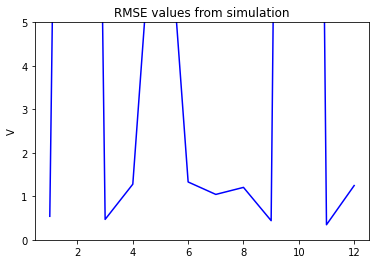

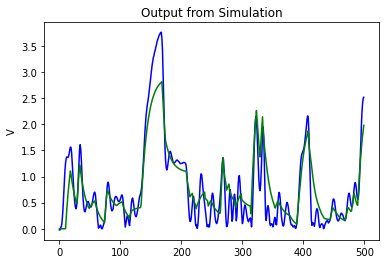

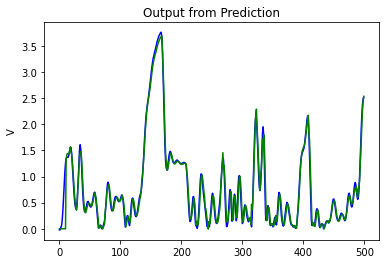

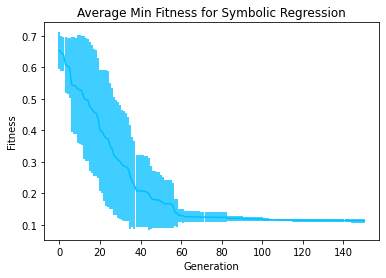

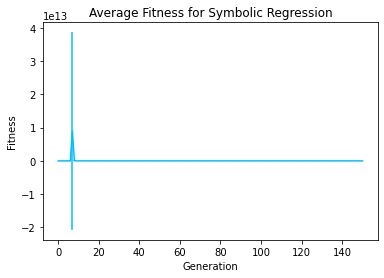

In [23]:
### Plots

plt.ylabel('V')
plt.title('RMSE values from simulation')
plt.plot(np.arange(1, N_RUNS+1), simulation_RMSE, label="Val",color="Blue")
plt.ylim(0,5)
plt.show()


plt.ylabel('V')
plt.title('Output from Simulation')
plt.plot(np.arange(0, X_val_features.shape[1]), Y_val, label="Val",color="Blue")
plt.plot(np.arange(0, X_val_features.shape[1]), best_sim_output, label="Val",color="Green")
plt.show()


plt.ylabel('V')
plt.title('Output from Prediction')
plt.plot(np.arange(0, X_val_features.shape[1]), Y_val, label="Val",color="Blue")
plt.plot(np.arange(0, X_val_features.shape[1]), best_pred_output, label="Val",color="Green")
plt.show()


### Statistics

x_axis = np.arange(0, MAX_GENERATIONS+1)

min_Fitness_List = []
avg_Fitness_List = []

for Logbook in logbooks:
    
    min_Fitness_List.append(Logbook.select("min"))
    avg_Fitness_List.append(Logbook.select("avg"))

min_Fitness_List = np.array(min_Fitness_List)
avg_Fitness_List = np.array(avg_Fitness_List)


plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Average Min Fitness for Symbolic Regression')
plt.errorbar(x_axis, min_Fitness_List.mean(0), yerr=min_Fitness_List.std(0),label="Avg", color="deepskyblue")
plt.show()


plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Average Fitness for Symbolic Regression')
plt.errorbar(x_axis, avg_Fitness_List.mean(0), yerr=avg_Fitness_List.std(0),label="Avg", color="deepskyblue")#
plt.show()